
Resumo Estatístico:
                Ano  Taxa_Abandono  Renda_Media
count   220.000000     220.000000   220.000000
mean   2018.000000       2.556773  2791.290909
std       3.169489       3.088679   574.340413
min    2013.000000       0.030000  1889.000000
25%    2015.000000       0.500000  2147.000000
50%    2018.000000       1.200000  3147.000000
75%    2021.000000       3.477500  3261.000000
max    2023.000000      14.000000  3451.000000


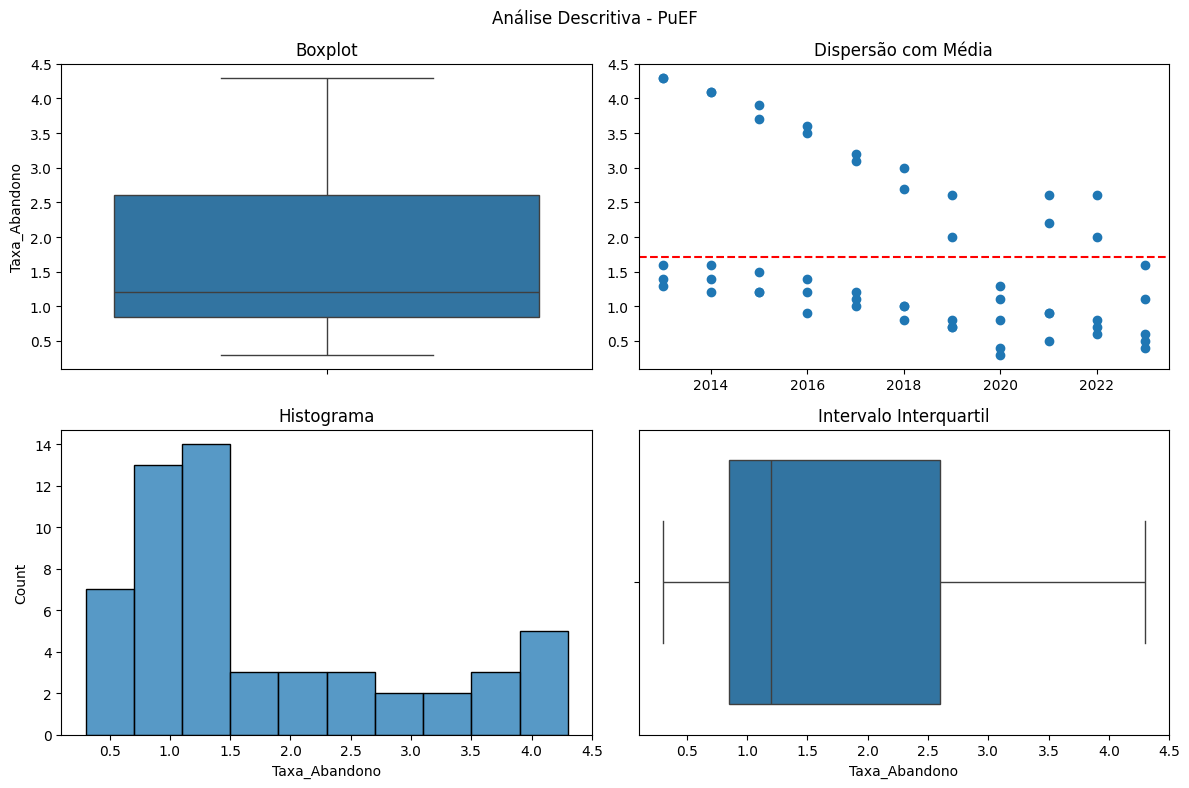

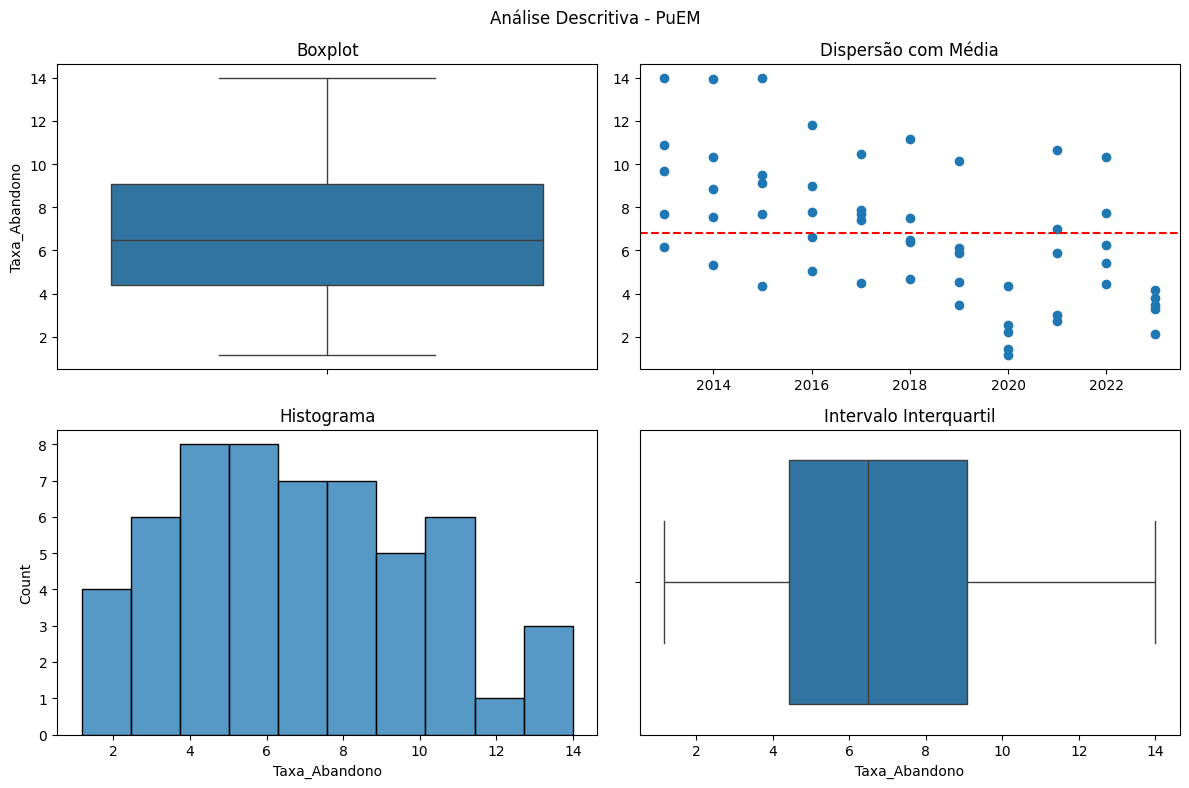

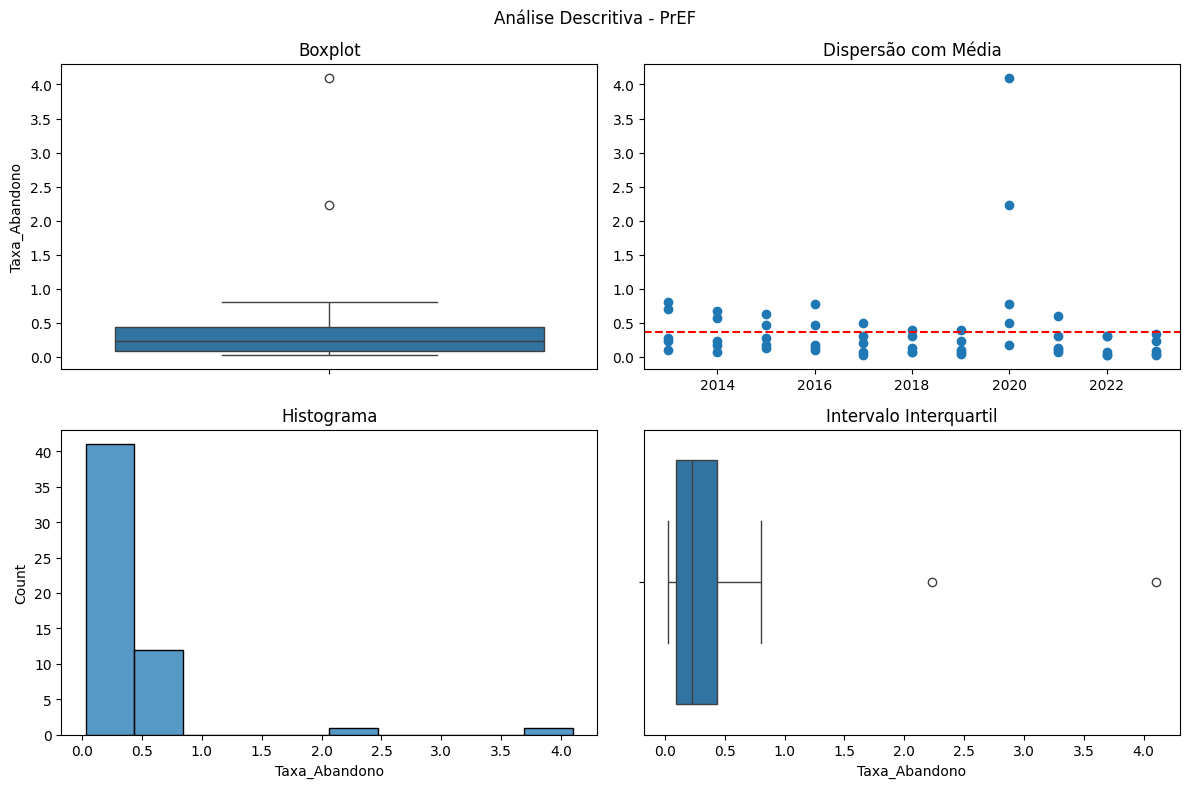

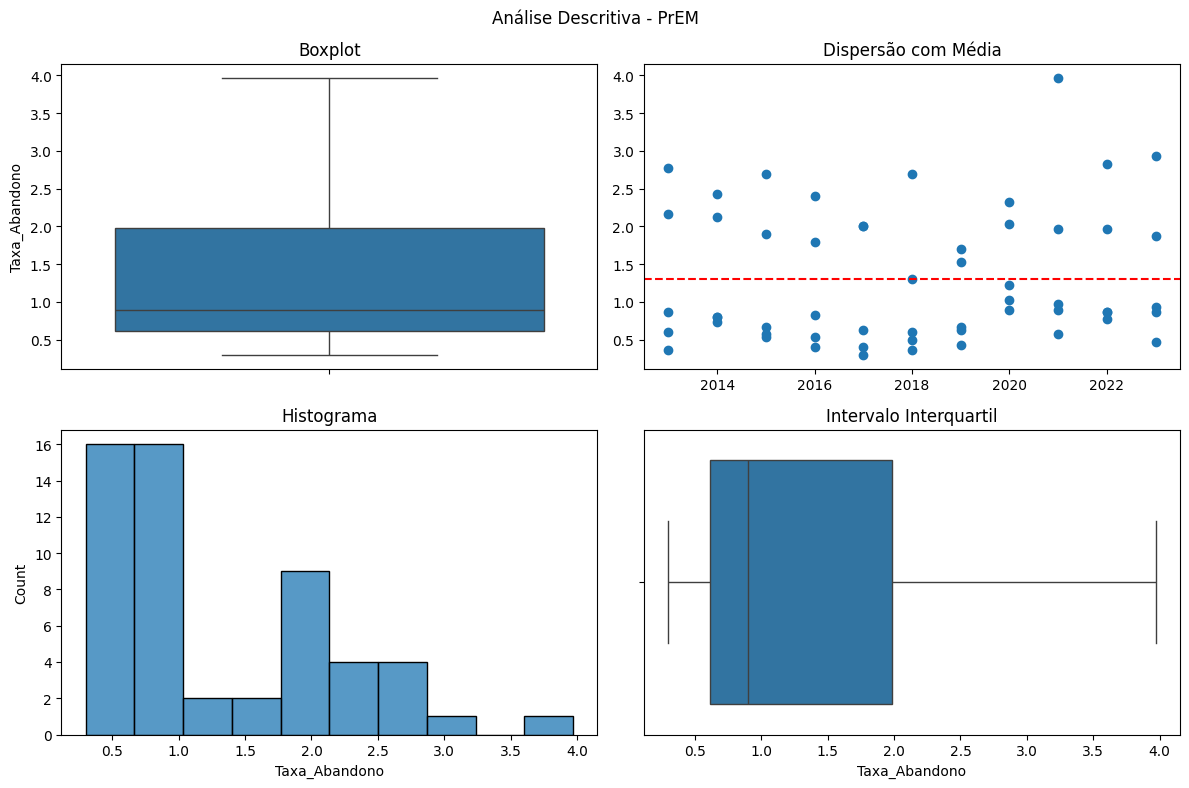

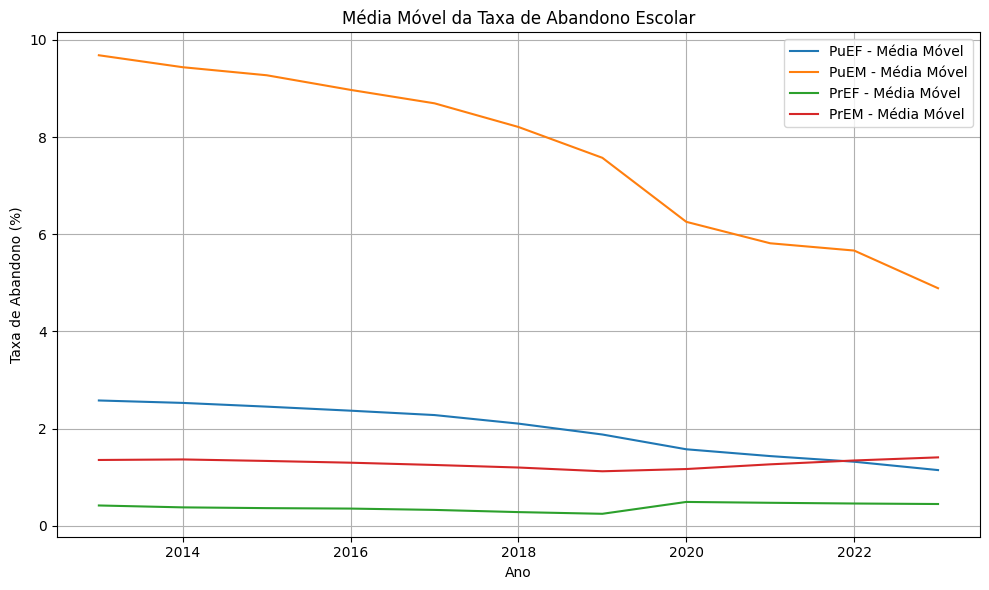

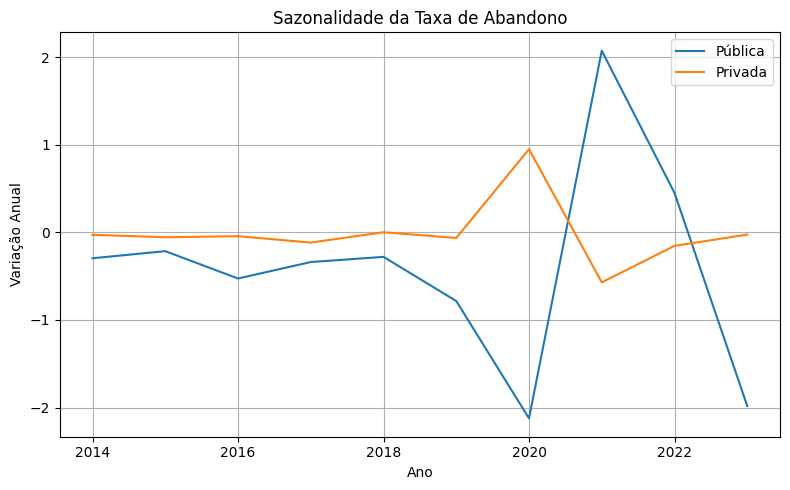


Clusterização por Região:
 Unidade_Geografica
Centro-Oeste    2
Nordeste        0
Norte           0
Sudeste         1
Sul             1
Name: Cluster, dtype: int32


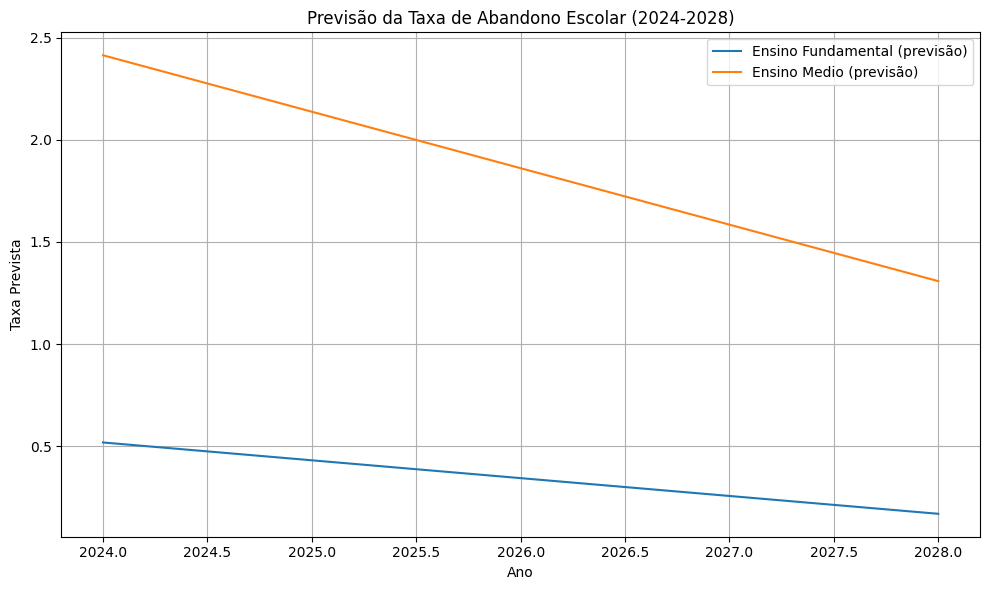

In [ ]:
# Google Colab - Análise e Predição da Taxa de Abandono Escolar

# 1. Importação de Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 2. Leitura do Arquivo Excel
data = pd.read_excel("TCC EXEL.xlsx")

# 3. Análise Descritiva
print("\nResumo Estatístico:\n", data.describe())

# 4. Gráficos Descritivos por Grupo
grupos = { "PuEF": data[(data["Dependencia_Administrativa"] == "Publica") & (data["Grupo_de_Abandono"] == "Ensino Fundamental")],
    "PuEM": data[(data["Dependencia_Administrativa"] == "Publica") & (data["Grupo_de_Abandono"] == "Ensino Medio")],
    "PrEF": data[(data["Dependencia_Administrativa"] == "Privada") & (data["Grupo_de_Abandono"] == "Ensino Fundamental")],
    "PrEM": data[(data["Dependencia_Administrativa"] == "Privada") & (data["Grupo_de_Abandono"] == "Ensino Medio")]
}
for nome, grupo in grupos.items():
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Análise Descritiva - {nome}")
    plt.subplot(2, 2, 1)
    sns.boxplot(y=grupo["Taxa_Abandono"])
    plt.title("Boxplot")
    plt.subplot(2, 2, 2)
    plt.scatter(grupo["Ano"], grupo["Taxa_Abandono"])
    plt.axhline(grupo["Taxa_Abandono"].mean(), color='r', linestyle='--')
    plt.title("Dispersão com Média")
    plt.subplot(2, 2, 3)
    sns.histplot(grupo["Taxa_Abandono"], bins=10)
    plt.title("Histograma")
    plt.subplot(2, 2, 4)
    sns.boxplot(x=grupo["Taxa_Abandono"], orient='h')
    plt.title("Intervalo Interquartil")
    plt.tight_layout()
    plt.savefig(f"{nome}_analise.png")
    plt.show()

# 5. Média Móvel
media_movel_grupos = {}
for nome, grupo in grupos.items():
    media_por_ano = grupo.groupby("Ano")["Taxa_Abandono"].mean().sort_index()
    media_movel = media_por_ano.rolling(window=5, min_periods=1).mean()
    media_movel_grupos[nome] = media_movel

plt.figure(figsize=(10, 6))
for nome, serie in media_movel_grupos.items():
    plt.plot(serie.index, serie.values, label=f"{nome} - Média Móvel")
plt.title("Média Móvel da Taxa de Abandono Escolar")
plt.xlabel("Ano")
plt.ylabel("Taxa de Abandono (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("media_movel.png")
plt.show()

# 6. Sazonalidade
pub = data[data["Dependencia_Administrativa"] == "Publica"].groupby("Ano")["Taxa_Abandono"].mean().diff()
pri = data[data["Dependencia_Administrativa"] == "Privada"].groupby("Ano")["Taxa_Abandono"].mean().diff()
plt.figure(figsize=(8, 5))
plt.plot(pub.index, pub.values, label="Pública")
plt.plot(pri.index, pri.values, label="Privada")
plt.title("Sazonalidade da Taxa de Abandono")
plt.xlabel("Ano")
plt.ylabel("Variação Anual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("sazonalidade.png")
plt.show()

# 7. Clusterização por Região
pivot = data.groupby(["Unidade_Geografica", "Ano"])["Taxa_Abandono"].mean().unstack().fillna(0)
scaled = StandardScaler().fit_transform(pivot)
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
pivot["Cluster"] = kmeans.fit_predict(scaled)
print("\nClusterização por Região:\n", pivot["Cluster"])

# 8. Predição (Regressão Linear)
df_preds = data.groupby(["Grupo_de_Abandono", "Ano"])["Taxa_Abandono"].mean().reset_index()
plt.figure(figsize=(10, 6))
for grupo in df_preds["Grupo_de_Abandono"].unique():
    subset = df_preds[df_preds["Grupo_de_Abandono"] == grupo]
    X = subset["Ano"].values.reshape(-1, 1)
    y = subset["Taxa_Abandono"].values
    model = LinearRegression().fit(X, y)
    anos_futuros = np.arange(2024, 2029).reshape(-1, 1)
    y_pred = model.predict(anos_futuros)
    plt.plot(anos_futuros, y_pred, label=f"{grupo} (previsão)")
plt.title("Previsão da Taxa de Abandono Escolar (2024-2028)")
plt.xlabel("Ano")
plt.ylabel("Taxa Prevista")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("previsao_abandono.png")
plt.show()

In [ ]:
# 9. Testes Estatísticos por Grupo
for nome, grupo in grupos.items():
    print(f"\nGrupo: {nome}")
    valores = grupo["Taxa_Abandono"].dropna()
    media = valores.mean()
    print("Teste T (média vs mediana):", ttest_1samp(valores, valores.median()).pvalue)
    print("Shapiro-Wilk (normalidade):", shapiro(valores).pvalue)
    for outro_nome in grupos:
        if outro_nome != nome:
            _, p = levene(grupos[nome]["Taxa_Abandono"].dropna(), grupos[outro_nome]["Taxa_Abandono"].dropna())
            print(f"Levene com {outro_nome}:", p)

# 10. ANOVA de Welch
pu = grupos["PuEF"]["Taxa_Abandono"].dropna()
pr1 = grupos["PrEF"]["Taxa_Abandono"].dropna()
pr2 = grupos["PrEM"]["Taxa_Abandono"].dropna()
print("\nANOVA Welch PuEF x PrEF:", ttest_ind(pu, pr1, equal_var=False).pvalue)
print("ANOVA Welch PuEF x PrEM:", ttest_ind(pu, pr2, equal_var=False).pvalue)

# 11. Modelos Preditivos Avançados (Random Forest, XGBoost, KNN, SVM, ANN etc.)

# Codificação de variáveis categóricas
data_encoded = pd.get_dummies(data, columns=["Dependencia_Administrativa", "Grupo_de_Abandono", "Unidade_Geografica"], drop_first=True)

# Variáveis explicativas e alvo
X = data_encoded.drop(columns=["Taxa_Abandono"])
y = data_encoded["Taxa_Abandono"]

# Treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Importação de todos os modelos
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Lista de modelos
modelos = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVM": SVR(kernel="rbf"),
    "ANN (MLP)": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Avaliação
from sklearn.metrics import mean_absolute_error, r2_score
resultados = []

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    resultados.append({
        "Modelo": nome,
        "MAE": round(mae, 4),
        "R²": round(r2, 4)
    })

# Mostrar os resultados
resultados_df = pd.DataFrame(resultados).sort_values("R²", ascending=False)
print("\n📊 Desempenho dos Modelos:\n")
print(resultados_df)





Grupo: PuEF
Teste T (média vs mediana): 0.001966274561059438
Shapiro-Wilk (normalidade): 1.4923226317140905e-05
Levene com PuEM: 1.572500890317794e-08
Levene com PrEF: 7.419457777551104e-05
Levene com PrEM: 0.22246325233862058

Grupo: PuEM
Teste T (média vs mediana): 0.44707869784055077
Shapiro-Wilk (normalidade): 0.2289096118275356
Levene com PuEF: 1.572500890317794e-08
Levene com PrEF: 2.727581829633501e-14
Levene com PrEM: 1.2928742052408495e-10

Grupo: PrEF
Teste T (média vs mediana): 0.09414888236468542
Shapiro-Wilk (normalidade): 1.0671713121358557e-12
Levene com PuEF: 7.419457777551104e-05
Levene com PuEM: 2.727581829633501e-14
Levene com PrEM: 0.0006741936278930479

Grupo: PrEM
Teste T (média vs mediana): 0.0009537543776375284
Shapiro-Wilk (normalidade): 5.101666633185089e-05
Levene com PuEF: 0.22246325233862058
Levene com PuEM: 1.2928742052408495e-10
Levene com PrEF: 0.0006741936278930479

ANOVA Welch PuEF x PrEF: 6.012404415755949e-11
ANOVA Welch PuEF x PrEM: 0.0428435597827

In [ ]:

# Carregar os dados da aba "Todos"
file_path = '/content/TCC EXEL.xlsx'
data = pd.read_excel(file_path, sheet_name='Todos')

# Verificando os dados
data.head()


,Ano,Unidade_Geografica,Dependencia_Administrativa,Grupo_de_Abandono,Taxa_Abandono,Renda_Media
0,2013,Norte,Publica,Ensino Medio,13.97,2252
1,2013,Nordeste,Publica,Ensino Medio,10.87,1976
2,2013,Sudeste,Publica,Ensino Medio,6.17,3306
3,2013,Sul,Publica,Ensino Medio,7.70,3194
4,2013,Centro-Oeste,Publica,Ensino Medio,9.70,3299


In [ ]:

# Converter possíveis colunas com data para float
data['Taxa_Abandono'] = pd.to_numeric(data['Taxa_Abandono'], errors='coerce')
data['Renda_Media'] = pd.to_numeric(data['Renda_Media'], errors='coerce')
data.dropna(inplace=True)

# Resetar índices
data.reset_index(drop=True, inplace=True)
data.head()


,Ano,Unidade_Geografica,Dependencia_Administrativa,Grupo_de_Abandono,Taxa_Abandono,Renda_Media
0,2013,Norte,Publica,Ensino Medio,13.97,2252
1,2013,Nordeste,Publica,Ensino Medio,10.87,1976
2,2013,Sudeste,Publica,Ensino Medio,6.17,3306
3,2013,Sul,Publica,Ensino Medio,7.70,3194
4,2013,Centro-Oeste,Publica,Ensino Medio,9.70,3299


,Ano,Taxa_Abandono,Renda_Media
count,220.000000,220.000000,220.000000
mean,2018.000000,2.556773,2791.290909
std,3.169489,3.088679,574.340413
min,2013.000000,0.030000,1889.000000
25%,2015.000000,0.500000,2147.000000
50%,2018.000000,1.200000,3147.000000
75%,2021.000000,3.477500,3261.000000
max,2023.000000,14.000000,3451.000000


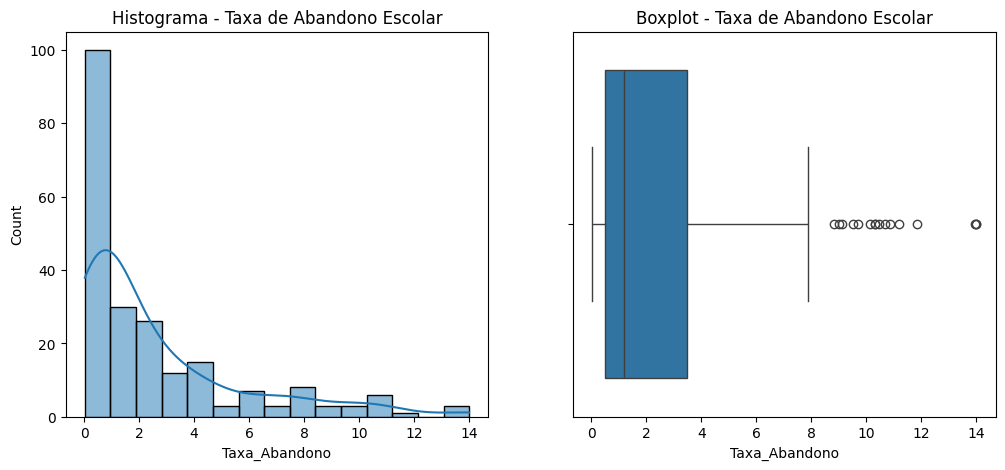

In [ ]:

# Estatísticas descritivas
display(data.describe())

# Histograma e boxplot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(data['Taxa_Abandono'], kde=True)
plt.title('Histograma - Taxa de Abandono Escolar')

plt.subplot(1,2,2)
sns.boxplot(x=data['Taxa_Abandono'])
plt.title('Boxplot - Taxa de Abandono Escolar')
plt.show()



Correlação entre Taxa de Abandono e Renda Média:
               Taxa_Abandono  Renda_Media
Taxa_Abandono       1.000000    -0.261347
Renda_Media        -0.261347     1.000000


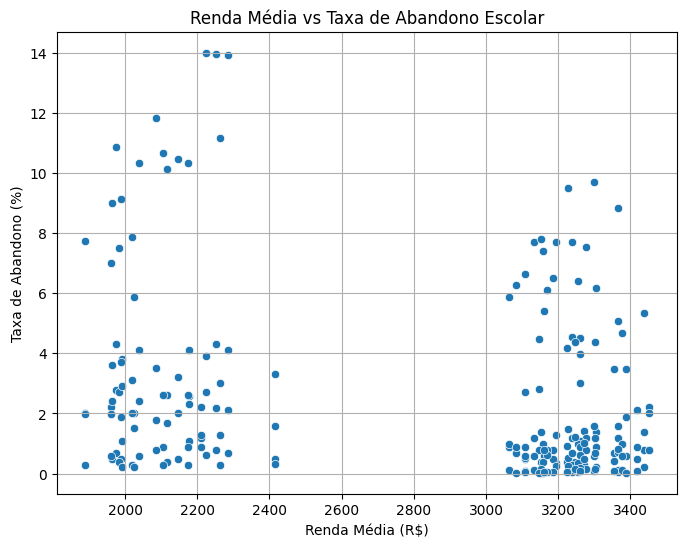

In [ ]:

# Correlação entre taxa de abandono e renda média
correlation = data[['Taxa_Abandono', 'Renda_Media']].corr()
print("Correlação entre Taxa de Abandono e Renda Média:")
print(correlation)

# Dispersão
plt.figure(figsize=(8,6))
sns.scatterplot(x='Renda_Media', y='Taxa_Abandono', data=data)
plt.title('Renda Média vs Taxa de Abandono Escolar')
plt.xlabel('Renda Média (R$)')
plt.ylabel('Taxa de Abandono (%)')
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

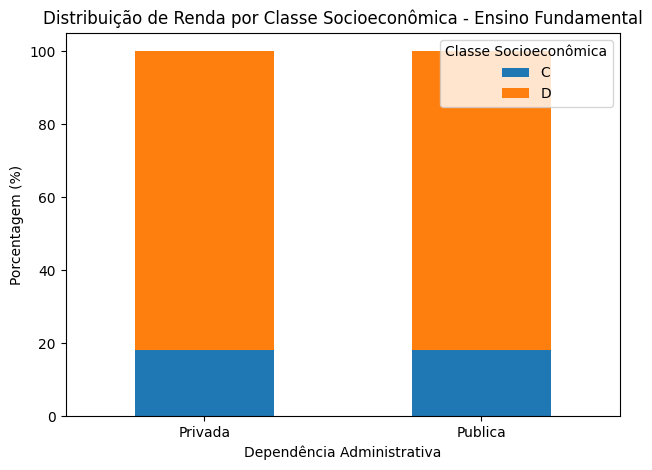

<Figure size 1000x600 with 0 Axes>

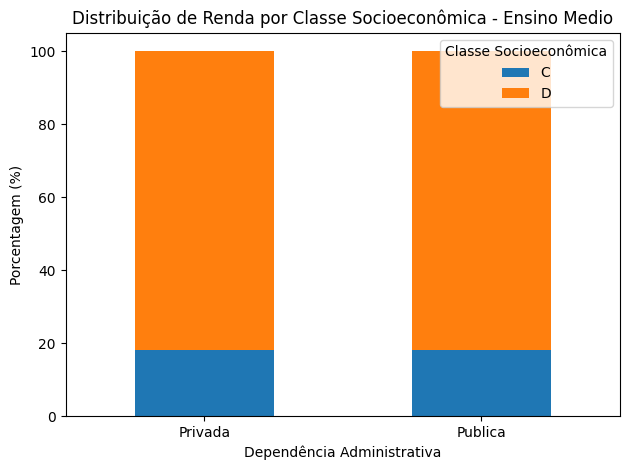

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt



# Classificação de renda em classes socioeconômicas
def classificar_renda(renda):
    if renda <= 1600:
        return 'E'
    elif 1601 <= renda <= 3300:
        return 'D'
    elif 3301 <= renda <= 8000:
        return 'C'
    elif 8001 <= renda <= 24800:
        return 'B'
    else:
        return 'A'

data['Classe_Socioeconomica'] = data['Renda_Media'].apply(classificar_renda)

# Agrupamento e porcentagem por classe, grupo de abandono e dependência administrativa
agrupado = data.groupby(['Grupo_de_Abandono', 'Dependencia_Administrativa', 'Classe_Socioeconomica'])['Taxa_Abandono'].count().unstack().fillna(0)
totais = agrupado.sum(axis=1)
porcentagens = agrupado.div(totais, axis=0) * 100

# Gráficos de barras para cada grupo de abandono
for grupo_abandono in porcentagens.index.get_level_values(0).unique():
    plt.figure(figsize=(10, 6))
    porcentagens.loc[grupo_abandono].plot(kind='bar', stacked=True)
    plt.title(f'Distribuição de Renda por Classe Socioeconômica - {grupo_abandono}')
    plt.xlabel('Dependência Administrativa')
    plt.ylabel('Porcentagem (%)')
    plt.xticks(rotation=0)
    plt.legend(title='Classe Socioeconômica')
    plt.tight_layout()
    plt.show()


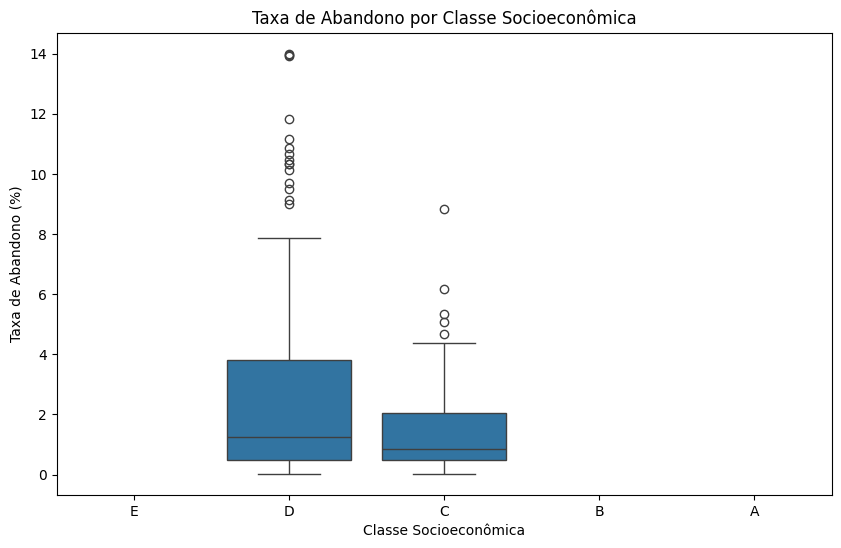

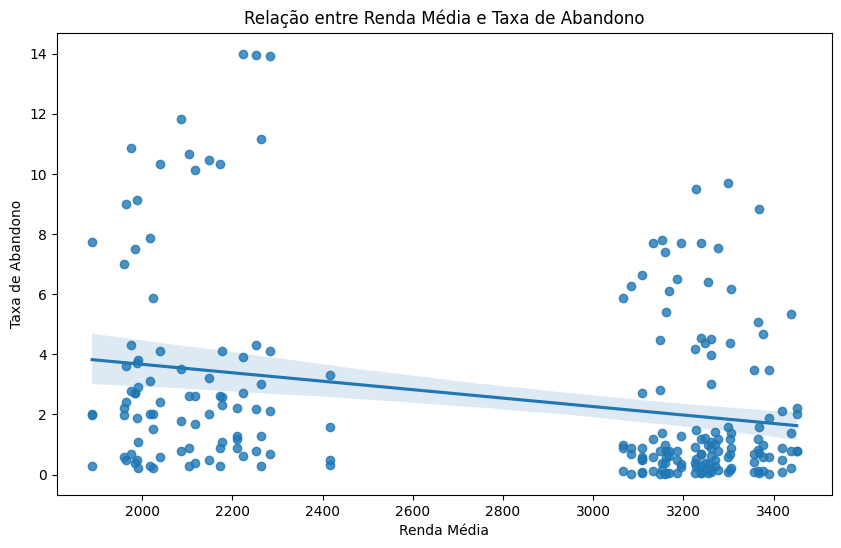

In [ ]:

import matplotlib.pyplot as plt

# Correlação entre classe econômica e taxa de abandono
plt.figure(figsize=(10, 6))
sns.boxplot(x='Classe_Socioeconomica', y='Taxa_Abandono', data=data, order=['E', 'D', 'C', 'B', 'A'])
plt.title('Taxa de Abandono por Classe Socioeconômica')
plt.xlabel('Classe Socioeconômica')
plt.ylabel('Taxa de Abandono (%)')
plt.show()

# Gráfico de dispersão com regressão linear
plt.figure(figsize=(10, 6))
sns.regplot(x='Renda_Media', y='Taxa_Abandono', data=data)
plt.title('Relação entre Renda Média e Taxa de Abandono')
plt.xlabel('Renda Média')
plt.ylabel('Taxa de Abandono')
plt.show()


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd



# Prepare the data for classification (assuming 'Taxa_Abandono' is your target variable)
# Convert 'Taxa_Abandono' to binary classes (e.g., above/below a threshold)
threshold = data['Taxa_Abandono'].median() # You can adjust this threshold as needed
data['Abandono'] = (data['Taxa_Abandono'] > threshold).astype(int)

# Features (X) and target (y)
X = data[['Renda_Media']] # Include other relevant features
y = data['Abandono']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Regressão Logística": LogisticRegression(random_state=42, max_iter=1000),  # Increased max_iter
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=42),
    "ANN": MLPClassifier(random_state=42, max_iter=500), #Increased max_iter
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # Added parameters
}


results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results.append([name, accuracy, precision, recall, f1, cm])


# Create a DataFrame for results
results_df = pd.DataFrame(results, columns=["Modelo", "Acurácia", "Precisão", "Recall", "F1-Score", "Matriz de Confusão"])
results_df = results_df.set_index('Modelo')

# Display the results with two decimal places
pd.options.display.float_format = '{:.2f}'.format
results_df


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:37:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Acurácia,Precisão,Recall,F1-Score,Matriz de Confusão
Modelo,,,,,
Random Forest,0.61,0.58,0.71,0.64,"[[12, 11], [6, 15]]"
Gradient Boosting,0.75,0.75,0.71,0.73,"[[18, 5], [6, 15]]"
Regressão Logística,0.82,0.78,0.86,0.82,"[[18, 5], [3, 18]]"
KNN,0.73,0.68,0.81,0.74,"[[15, 8], [4, 17]]"
SVM,0.82,0.78,0.86,0.82,"[[18, 5], [3, 18]]"
ANN,0.52,0.00,0.00,0.00,"[[23, 0], [21, 0]]"
XGBoost,0.70,0.68,0.71,0.70,"[[16, 7], [6, 15]]"


In [ ]:
# Carregar os dados da aba "Todos"
file_path = '/content/TCC EXEL.xlsx'
data = pd.read_excel(file_path, sheet_name='Todos')

# Verificando os dados
data.head()

# Converter possíveis colunas com data para float
data['Taxa_Abandono'] = pd.to_numeric(data['Taxa_Abandono'], errors='coerce')
data['Renda_Media'] = pd.to_numeric(data['Renda_Media'], errors='coerce')

# Check if the DataFrame is empty after conversion
if data.empty:
    print("DataFrame is empty after conversion. Check your data and preprocessing steps.")
else:
    data.dropna(inplace=True)

    # Resetar índices
    data.reset_index(drop=True, inplace=True)
    data.head()


In [ ]:
# 11. Modelos Preditivos Avançados (Random Forest, XGBoost, KNN, SVM, ANN etc.)

# Codificação de variáveis categóricas
data_encoded = pd.get_dummies(data, columns=["Dependencia_Administrativa", "Grupo_de_Abandono", "Unidade_Geografica"], drop_first=True)

# Variáveis explicativas e alvo
X = data_encoded.drop(columns=["Taxa_Abandono"])
y = data_encoded["Taxa_Abandono"]

# Treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Importação de todos os modelos
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Lista de modelos
modelos = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVM": SVR(kernel="rbf"),
    "ANN (MLP)": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Avaliação
from sklearn.metrics import mean_absolute_error, r2_score
resultados = []

for nome, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    resultados.append({
        "Modelo": nome,
        "MAE": round(mae, 4),
        "R²": round(r2, 4)
    })

# Mostrar os resultados
resultados_df = pd.DataFrame(resultados).sort_values("R²", ascending=False)
print("\n📊 Desempenho dos Modelos:\n")
print(resultados_df)





📊 Desempenho dos Modelos:

              Modelo   MAE      R²
1      Random Forest  0.69    0.86
2  Gradient Boosting  0.77    0.85
6            XGBoost  0.92    0.72
0  Linear Regression  1.43    0.68
3                KNN  2.42    0.07
4                SVM  1.92   -0.03
5          ANN (MLP) 44.79 -181.03


In [ ]:
# prompt:     "Faça uma análise de regressão linear simples para cada região, considerando o ano como variável independente (X) e a taxa de abandono escolar como variável dependente (Y). Para cada região (Centro-Oeste, Nordeste, Norte, Sudeste, Sul), extraia:
#         o coeficiente angular (tendência da linha),
#         o intercepto da regressão,
#         o R² da regressão.
#     Depois, organize esses resultados em uma tabela com as colunas: Região | Coeficiente Angular (tendência) | Intercepto | R²."

import pandas as pd
# Create an empty list to store the results
results = []

# Loop through each region
for region in data['Unidade_Geografica'].unique():
    # Filter data for the current region
    region_data = data[data['Unidade_Geografica'] == region]

    # Prepare the data for regression
    X = region_data['Ano'].values.reshape(-1, 1)
    y = region_data['Taxa_Abandono']

    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Extract the coefficients and R-squared
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X, y)

    # Append the results to the list
    results.append([region, slope, intercept, r_squared])

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['Região', 'Coeficiente Angular (tendência)', 'Intercepto', 'R²'])

# Display the DataFrame
results_df

,Região,Coeficiente Angular (tendência),Intercepto,R²
0,Norte,-0.34,695.62,0.06
1,Nordeste,-0.23,458.67,0.06
2,Sudeste,-0.03,55.74,0.00
3,Sul,-0.09,184.89,0.01
4,Centro-Oeste,-0.22,452.08,0.06


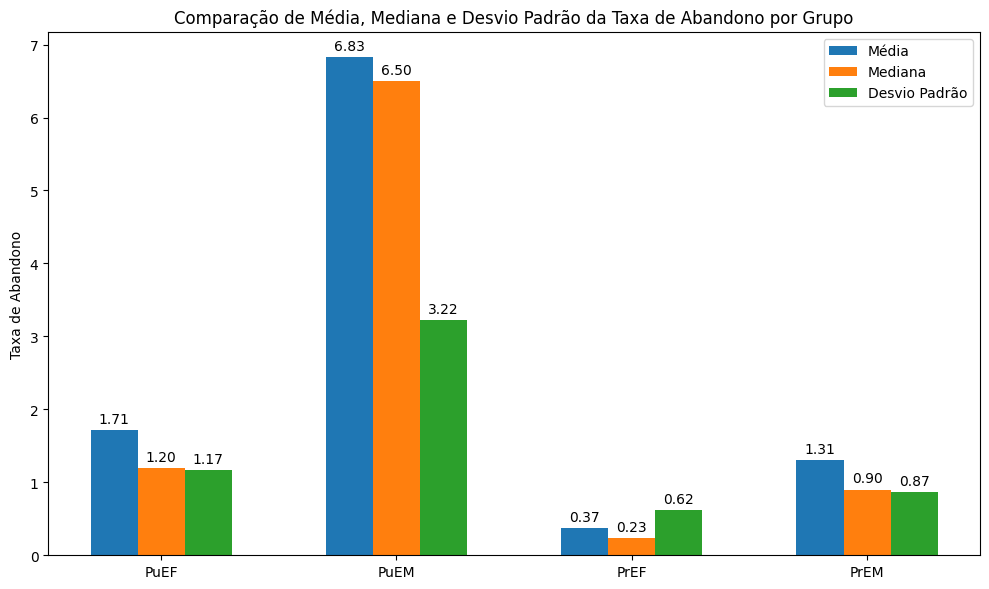

In [ ]:
# prompt: faça um gráfico que mostra barras agrupadas para cada grupo de escola (PuEF, PuEM, PrEF, PrEM) com três medidas: média, mediana e desvio padrão da taxa de abandono.

import matplotlib.pyplot as plt

# Calculate mean, median, and standard deviation for each group
group_stats = {}
for name, group in grupos.items():
    group_stats[name] = {
        'mean': group['Taxa_Abandono'].mean(),
        'median': group['Taxa_Abandono'].median(),
        'std': group['Taxa_Abandono'].std()
    }

# Prepare data for bar plot
groups = list(group_stats.keys())
means = [group_stats[group]['mean'] for group in groups]
medians = [group_stats[group]['median'] for group in groups]
stds = [group_stats[group]['std'] for group in groups]

x = range(len(groups))
width = 0.2

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar([i - width for i in x], means, width, label='Média')
rects2 = ax.bar(x, medians, width, label='Mediana')
rects3 = ax.bar([i + width for i in x], stds, width, label='Desvio Padrão')


# Add labels, title, and legend
ax.set_ylabel('Taxa de Abandono')
ax.set_title('Comparação de Média, Mediana e Desvio Padrão da Taxa de Abandono por Grupo')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.legend()

# Add values on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)


plt.tight_layout()
plt.show()


In [ ]:
# prompt: quero uma tabela que apresenta os coeficientes obtidos a partir da aplicação de regressão linear simples para analisar a tendência da taxa de abandono escolar ao longo do tempo, segmentada por região do Brasil. O coeficiente angular indica a direção e a intensidade da tendência (Região
# Coeficiente Angular (tendência)
# Intercepto
# R²
# )

import pandas as pd
# Assuming 'data' DataFrame and necessary libraries are already imported and defined as in the provided code.
# ... (previous code)

# Create an empty list to store the results
results = []

# Loop through each region
for region in data['Unidade_Geografica'].unique():
    # Filter data for the current region
    region_data = data[data['Unidade_Geografica'] == region]

    # Prepare the data for regression
    X = region_data['Ano'].values.reshape(-1, 1)
    y = region_data['Taxa_Abandono']

    # Create and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Extract the coefficients and R-squared
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X, y)

    # Append the results to the list
    results.append([region, slope, intercept, r_squared])

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['Região', 'Coeficiente Angular (tendência)', 'Intercepto', 'R²'])

# Display the DataFrame
results_df


,Região,Coeficiente Angular (tendência),Intercepto,R²
0,Norte,-0.34,695.62,0.06
1,Nordeste,-0.23,458.67,0.06
2,Sudeste,-0.03,55.74,0.00
3,Sul,-0.09,184.89,0.01
4,Centro-Oeste,-0.22,452.08,0.06



Matriz de Correlação:
                Ano  Taxa_Abandono  Renda_Media
Ano            1.00          -0.19        -0.01
Taxa_Abandono -0.19           1.00        -0.26
Renda_Media   -0.01          -0.26         1.00


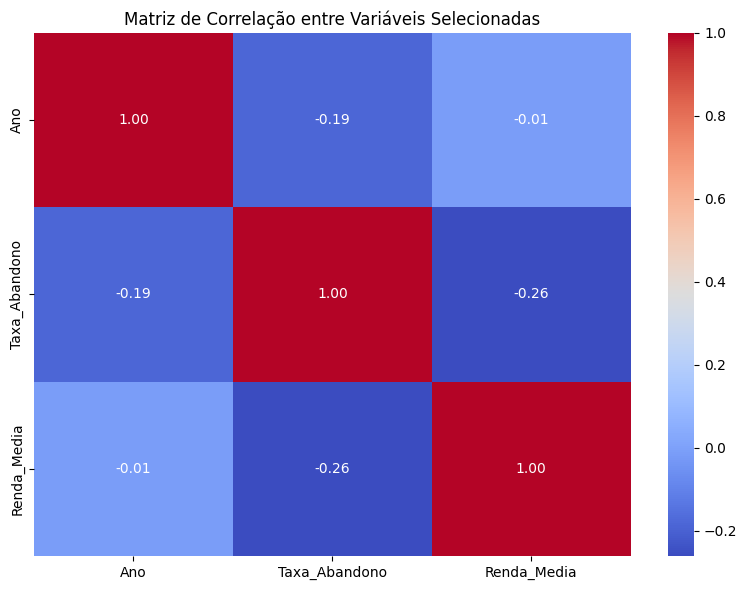

In [ ]:
# prompt: faça uma matriz de correlaçao entre as minhas variaveis: Ano, Unidade Geográfica, Renda Média, Taxa de Abandono,Dependência Administrativa,Grupo de Abandono

import matplotlib.pyplot as plt
# Selecionar as colunas relevantes para a matriz de correlação
colunas_correlacao = ["Ano", "Taxa_Abandono", "Renda_Media"]

# Calcular a matriz de correlação
matriz_correlacao = data[colunas_correlacao].corr()

# Exibir a matriz de correlação
print("\nMatriz de Correlação:")
print(matriz_correlacao)

# Visualizar a matriz de correlação usando um heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacao, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação entre Variáveis Selecionadas")
plt.tight_layout()
plt.show()
